Cell 1: Install & Import Libraries

In [1]:
# Install required libraries
!pip install nltk wordcloud transformers

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ------ --------------------------------- 1.8/12.0 MB 11.2 MB/s eta 0:00:01
   ---------- ----------------------------- 3.1/12.0 MB 8.4 MB/s eta 0:00:02
   ---------------- ----------------------- 5.0/12.0 MB 8.2 MB/s eta 0:00:01
   -------------------- ------------------- 6.3/12.0 MB 8.0 MB/s eta 0:00:01
   --------------------------- ------------ 8.1/12.0 MB 8.1 MB/s eta 0:00:01
   --------------------------------- ------ 10.0/12.0 MB 8.2 MB/s eta 0:00:01
   ------------------------------------ --- 11.0/12.0 MB 7.8 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/564.3 kB ? eta -:--:--
   ---------------------------------------- 564.3/564.3 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.7 MB 5.0 MB/s eta 0:00:01
   -----------

In [3]:
!pip install --upgrade tensorflow keras

In [ ]:
# Import Libraries

# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Visualization
from wordcloud import WordCloud
import plotly.express as px

# NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Classical ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, Callback

# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Cell 2: Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/"

aihc   Covid-19      finbank.ipynb    finyoutube.ipynb	MyPython.ipynb
AI-HC  DL-Exp.ipynb  finmarket.ipynb  merged.ipynb	Planner.ipynb


In [ ]:
# Change file path
%cd "/content/drive/MyDrive/Colab Notebooks/aihc/"

/content/drive/MyDrive/Colab Notebooks/aihc


In [ ]:
# Load train dataset
train_df = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')

# Load test dataset
test_df = pd.read_csv("Corona_NLP_test.csv", encoding='latin-1')

# Merge (optional) if you want one dataset
data = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
# Show basic info
print(data.shape)
print(data.head())
print(data.info())

(44955, 6)
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 

Cell 3: Data Understanding & Preprocessing

In [ ]:
# Check missing values
print(data.isnull().sum())

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [ ]:
# Drop duplicates if any
data.drop_duplicates(inplace=True)

In [ ]:
# Convert TweetAt column to datetime
data['TweetAt'] = pd.to_datetime(data['TweetAt'], errors='coerce')

/tmp/ipython-input-1557590350.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['TweetAt'] = pd.to_datetime(data['TweetAt'], errors='coerce')


In [ ]:
# Clean tweets function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|\#', '', text)  # Remove mentions & hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters & numbers
    tokens = text.split()
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

data['CleanTweet'] = data['OriginalTweet'].apply(clean_text)

data[['OriginalTweet','CleanTweet','Sentiment']].head()


,OriginalTweet,CleanTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,,Neutral
1,advice Talk to your neighbours family to excha...,advice talk neighbour family exchange phone nu...,Positive
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworth give elderly d...,Positive
3,My food stock is not the only one which is emp...,food stock one empty please dont panic enough ...,Positive
4,"Me, ready to go at supermarket during the #COV...",ready go supermarket covid outbreak im paranoi...,Extremely Negative


Cell 4: Exploratory Data Analysis (EDA)

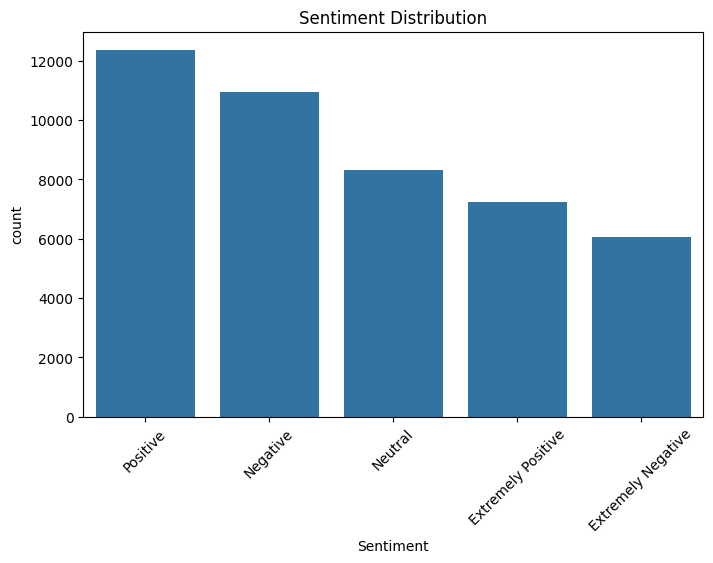

In [ ]:
# Distribution of sentiments
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='Sentiment', order=data['Sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.xticks(rotation=45)
plt.show()

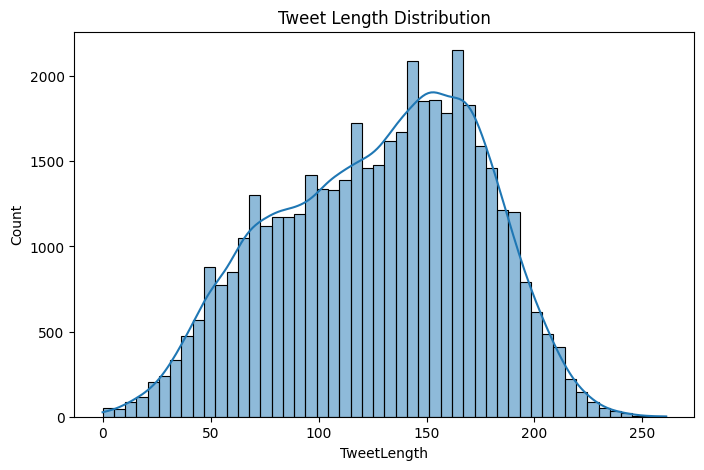

In [ ]:
# Tweet length distribution
data['TweetLength'] = data['CleanTweet'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(data['TweetLength'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.show()

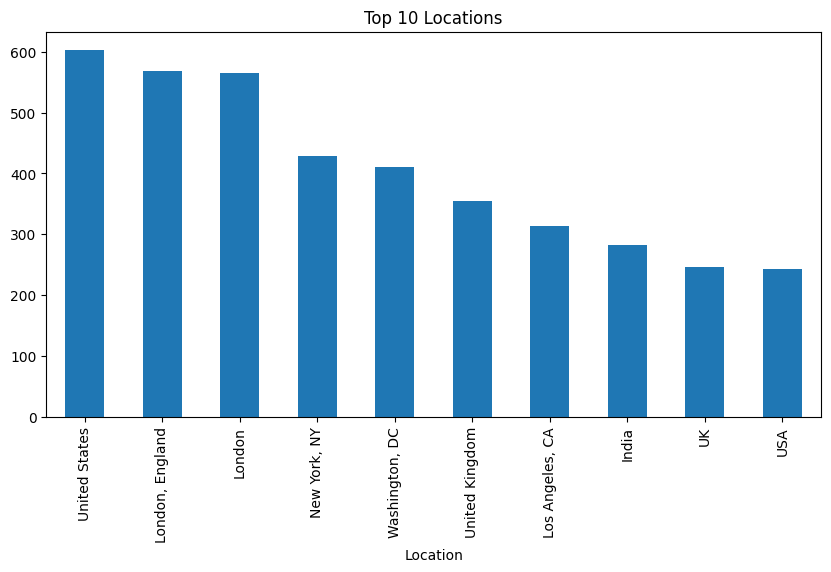

In [ ]:
# Top locations
plt.figure(figsize=(10,5))
data['Location'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Locations")
plt.show()

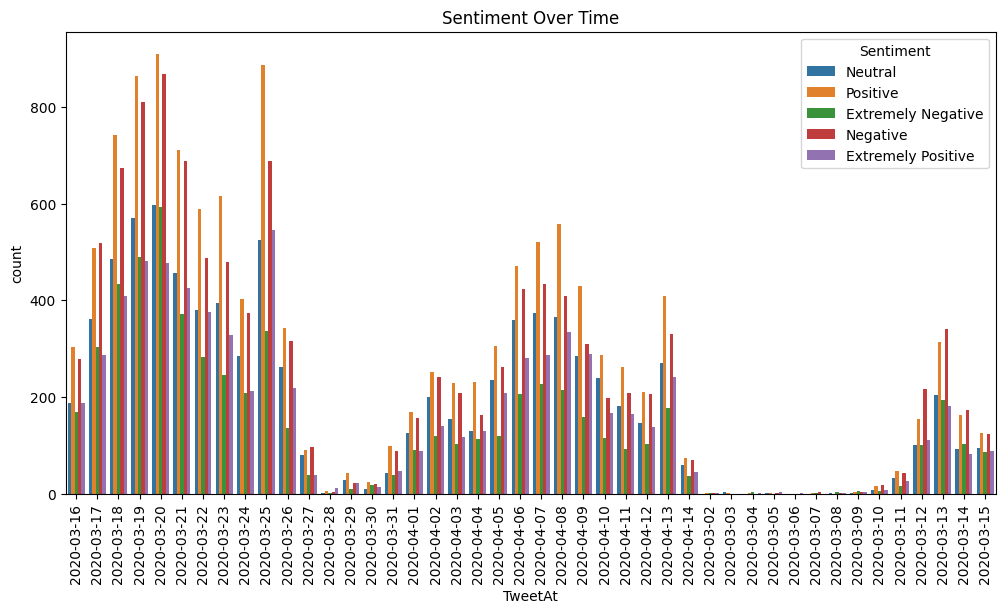

In [ ]:
# Sentiment over time
plt.figure(figsize=(12,6))
sns.countplot(data=data, x=data['TweetAt'].dt.date, hue='Sentiment')
plt.xticks(rotation=90)
plt.title("Sentiment Over Time")
plt.show()

Cell 5: Word Clouds

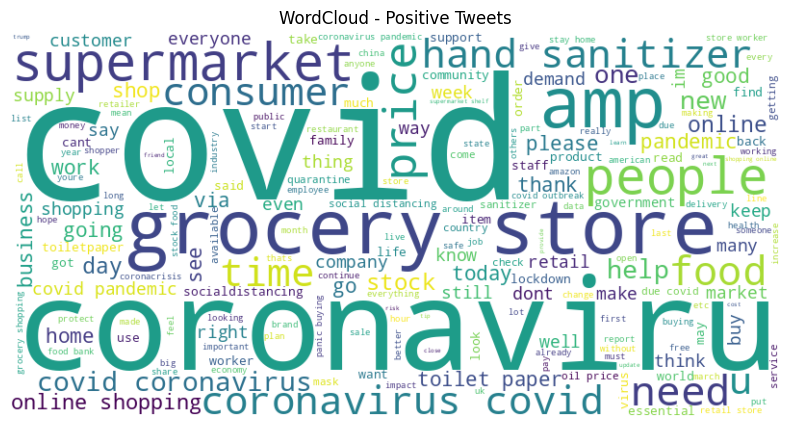

In [ ]:
# Positive Tweets
positive_text = " ".join(data[data['Sentiment']=='Positive']['CleanTweet'])
wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Positive Tweets")
plt.show()

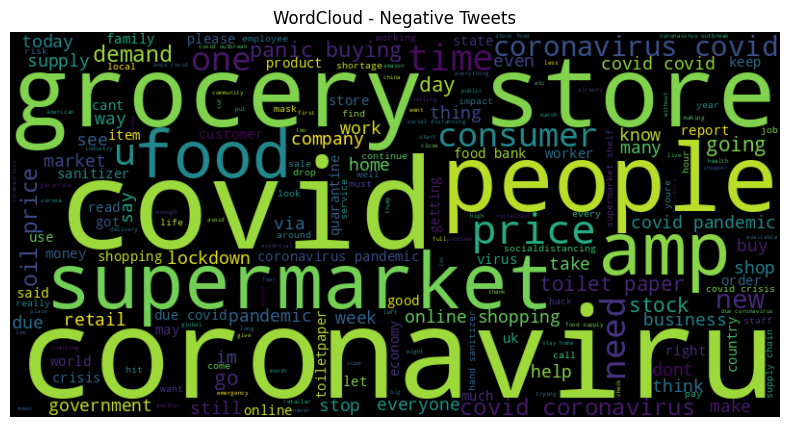

In [ ]:
# Negative Tweets
negative_text = " ".join(data[data['Sentiment']=='Negative']['CleanTweet'])
wc = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Negative Tweets")
plt.show()


Cell 6: Feature Engineering (TF-IDF)

In [ ]:
# Use TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['CleanTweet']).toarray()
y = data['Sentiment']

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cell 7: Model Building (Classical ML)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=le.classes_))



Logistic Regression Results:
Accuracy: 0.573462351240129
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.48      0.54      1189
Extremely Positive       0.69      0.53      0.60      1457
          Negative       0.52      0.52      0.52      2204
           Neutral       0.63      0.68      0.65      1681
          Positive       0.52      0.61      0.56      2460

          accuracy                           0.57      8991
         macro avg       0.60      0.57      0.58      8991
      weighted avg       0.58      0.57      0.57      8991


Naive Bayes Results:
Accuracy: 0.46624402179957736
                    precision    recall  f1-score   support

Extremely Negative       0.72      0.20      0.31      1189
Extremely Positive       0.70      0.25      0.36      1457
          Negative       0.43      0.55      0.48      2204
           Neutral       0.64      0.38      0.47      1681
          Positive       0.40      0.71      0

Cell 8: Confusion Matrix

<Figure size 1000x700 with 0 Axes>

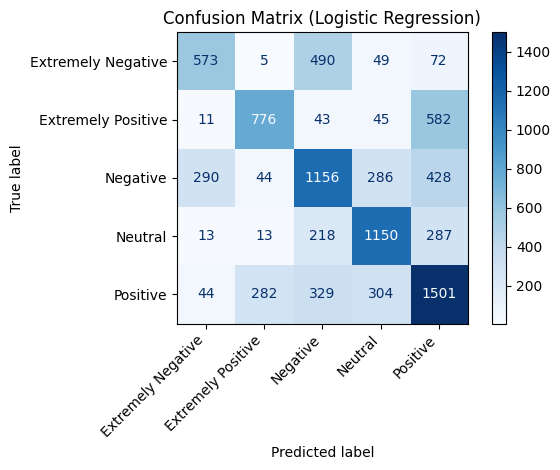

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 7))   # ✅ Balanced size
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=le.classes_,
    cmap="Blues"
)

plt.title("Confusion Matrix (Logistic Regression)")
plt.xticks(rotation=45, ha="right")   # ✅ Rotate x labels for clarity
plt.tight_layout()   # ✅ Adjust layout to avoid cut-offs
plt.show()

Cell 9: Sentiment Trend Analysis

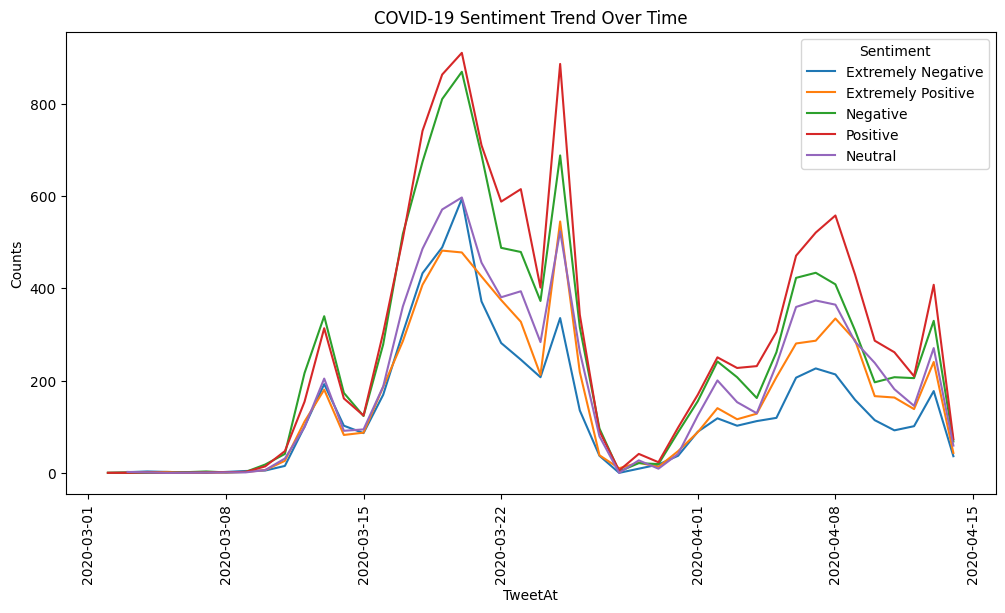

In [ ]:
# Group by date & sentiment
trend = data.groupby([data['TweetAt'].dt.date, 'Sentiment']).size().reset_index(name='Counts')

plt.figure(figsize=(12,6))
sns.lineplot(x='TweetAt', y='Counts', hue='Sentiment', data=trend)
plt.xticks(rotation=90)
plt.title("COVID-19 Sentiment Trend Over Time")
plt.show()

Cell 10: (Optional) Transformer Model (BERT/DistiBERT)

In [ ]:
from transformers import pipeline

sentiment_model = pipeline("sentiment-analysis")

# Test on sample
print(sentiment_model("COVID-19 vaccine is the best news ever!"))
print(sentiment_model("I am scared of coronavirus, this is terrible."))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998229146003723}]
[{'label': 'NEGATIVE', 'score': 0.999321699142456}]


Cell 11: Encode Sentiment Labels

In [ ]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['Sentiment'])

print(le.classes_)   # check encoded labels
print(data[['Sentiment','label']].head())


['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']
            Sentiment  label
0             Neutral      3
1            Positive      4
2            Positive      4
3            Positive      4
4  Extremely Negative      0


Cell 12: Tokenization & Padding

In [ ]:
X = data['CleanTweet']
y = data['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


Cell 13: Build LSTM Model

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Cell 14: Train Model

In [ ]:
# Custom callback to show percentages
class MetricsLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get("accuracy", 0) * 100
        val_acc = logs.get("val_accuracy", 0) * 100
        loss = logs.get("loss", 0)
        val_loss = logs.get("val_loss", 0)

        print(f"Epoch {epoch+1}: "
              f"accuracy={acc:.2f}%, "
              f"val_accuracy={val_acc:.2f}%, "
              f"loss={loss:.4f}, "
              f"val_loss={val_loss:.4f}")

# Early stopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[es, MetricsLogger()]
)


Epoch 1/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.3320 - loss: 1.4570Epoch 1: accuracy=43.77%, val_accuracy=63.11%, loss=1.2846, val_loss=0.9283
562/562 ━━━━━━━━━━━━━━━━━━━━ 259s 445ms/step - accuracy: 0.4377 - loss: 1.2846 - val_accuracy: 0.6311 - val_loss: 0.9283
Epoch 2/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6968 - loss: 0.8138Epoch 2: accuracy=71.08%, val_accuracy=72.72%, loss=0.7870, val_loss=0.7582
562/562 ━━━━━━━━━━━━━━━━━━━━ 239s 401ms/step - accuracy: 0.7108 - loss: 0.7870 - val_accuracy: 0.7272 - val_loss: 0.7582
Epoch 3/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7823 - loss: 0.6326Epoch 3: accuracy=77.87%, val_accuracy=74.25%, loss=0.6425, val_loss=0.7272
562/562 ━━━━━━━━━━━━━━━━━━━━ 250s 383ms/step - accuracy: 0.7787 - loss: 0.6425 - val_accuracy: 0.7425 - val_loss: 0.7272
Epoch 4/15
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8145 - loss: 0.5636Epoch 4: accuracy=80.81%, val_accuracy=74.61%, loss=0.5802, v

Cell 15: Model Evaluation

281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step
                    precision    recall  f1-score   support

Extremely Negative       0.76      0.76      0.76      1214
Extremely Positive       0.77      0.82      0.80      1445
          Negative       0.69      0.68      0.68      2192
           Neutral       0.81      0.77      0.79      1666
          Positive       0.72      0.72      0.72      2474

          accuracy                           0.74      8991
         macro avg       0.75      0.75      0.75      8991
      weighted avg       0.74      0.74      0.74      8991



<Figure size 800x600 with 0 Axes>

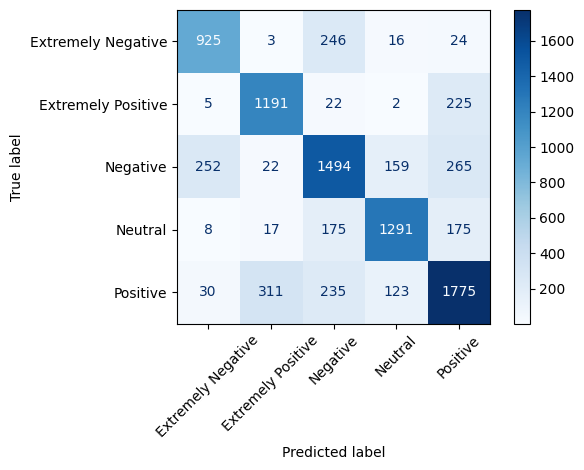

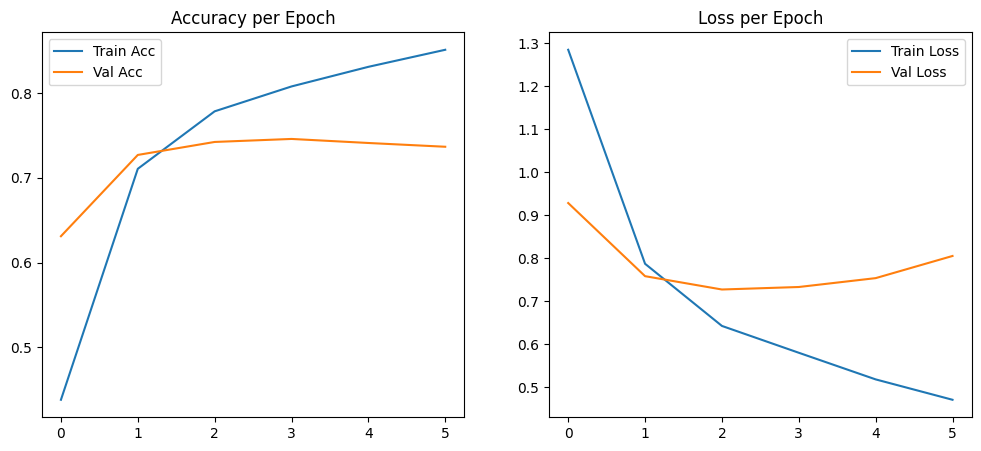

In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis=-1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap="Blues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accuracy/Loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.show()


Cell 16: Sentiment Trend Over Time

<Figure size 1200x600 with 0 Axes>

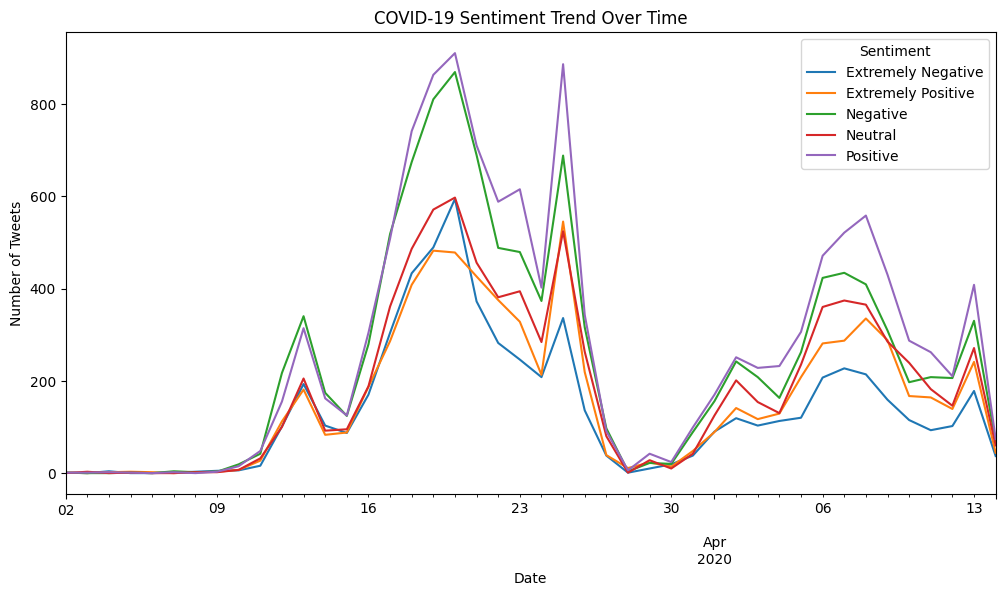

In [ ]:
data['TweetAt'] = pd.to_datetime(data['TweetAt'], errors='coerce')

sentiment_trend = data.groupby(['TweetAt','Sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(12,6))
sentiment_trend.plot(kind='line', figsize=(12,6))
plt.title("COVID-19 Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.show()
